In [1]:
# Modules
import numpy as np
import xarray as xr
import pandas as pd

from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing

# Description
rf004 Uses multiple predictors in Random Forest and optimizes HP with RandomSearchCV


# Next Steps

# Working Area

In [25]:
#---
# Load importance
#---
    # Get timeseries of predictor and predictand
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",]
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
season = "winter"
era5_import = "preprocess1"
model_run = "rf004"
percentile = 0.95

predictor_runs = [
    ["sp", "u10",], # run_id 0
    ["sp", "tp", "u10",], # run_id 1
    ["sp", "tp",],
    ["tp","u10"],
    ["sp", "tp", "u10", "v10"],
]

# Get lat,lons of this model run
lats, lons = preprocessing.get_lonlats(
    range_of_years,
    subregion,
    season,
    predictor="sp", # Does not matter which predictor. All predictors are sampled on same lon-lat field.
    era5_import=era5_import,
)

n_pred_features = len(lons) * len(lats) # Features per predictor (lon/lat Input-Field). Needed for importance separation

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter


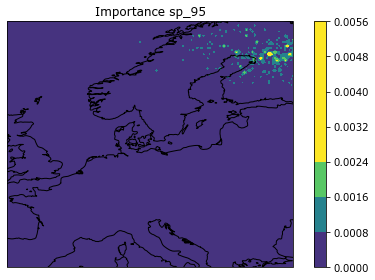

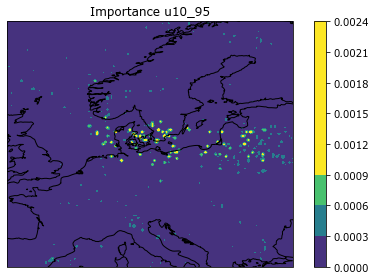

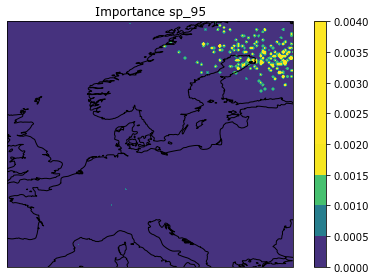

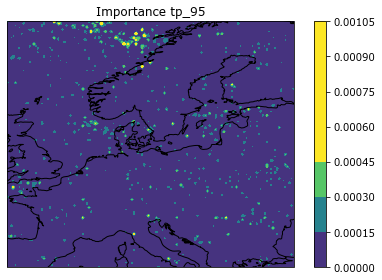

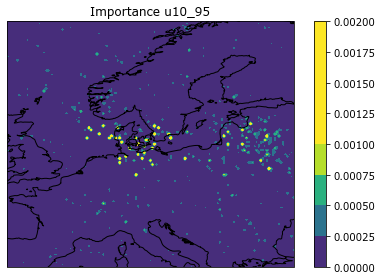

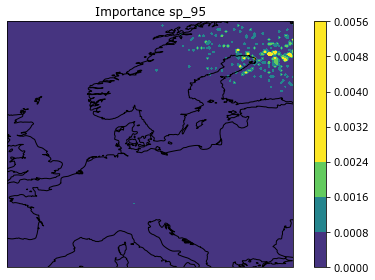

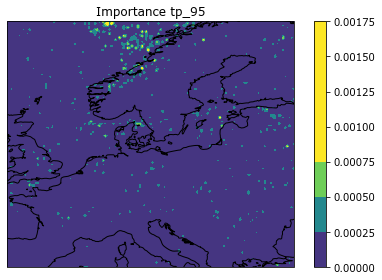

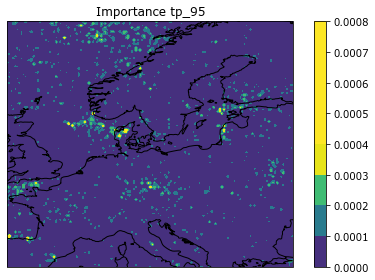

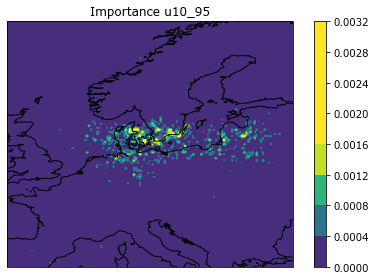

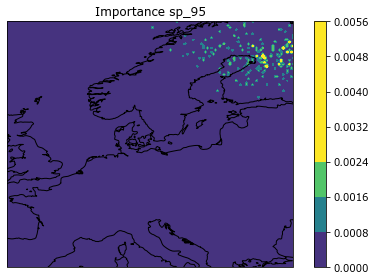

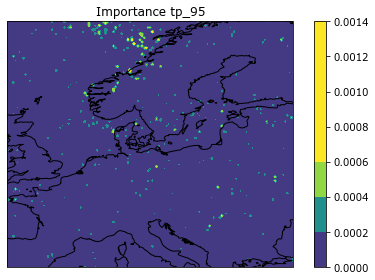

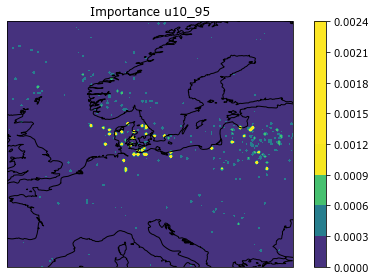

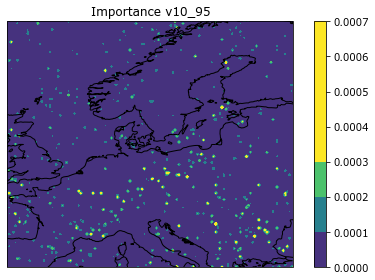

In [36]:
# Goal:
# 1. Separate importance per predictor (own function)
# 2. Plot importance of each predictor on lon lat map (function already exists)
from models import evaluation

for run_id, predictors in enumerate(predictor_runs): # Loop over runs of rf004

    # Load importance of that run
    folder = f"results/random_forest/{model_run}/"
    fname = f"importance_{str(percentile)[-2:]}_{run_id}"
    importance = np.load(f"{folder}{fname}.npy")
    predictor_importances = evaluation.separate_predictor_importance(importance, n_pred_features)

    for pred_idx, pred_importance in enumerate(predictor_importances):
        # Plot importance map and save it
        predictor = predictor_runs[run_id][pred_idx]
        tflag = f"{predictor}_{str(percentile)[-2:]}"

        fig = evaluation.importance_map(pred_importance, lons, lats, tflag)
        
        folder = f"results/random_forest/{model_run}/"
        fname = f"importance_{predictor}_{str(percentile)[-2:]}_{run_id}"
        fig.savefig(f"{folder}{fname}.pdf")

In [ ]:
#---
# Visualize Importance
#---

# Modularized Preprocessing

In [111]:
#---
# Modularize Preprocessing
#---

# Get timeseries of predictor and predictand
season = "winter" # ["winter", "autumn",] 
predictors = ["sp", "tp", "u10"]
percentile = 0.95 # [0.95, 0.99,] 
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",]
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
station_names = ["hanko-han-fin-cmems",]

In [109]:
#---
# Preprocess GESLA Data
#---

# Load Predictand
#---
gesla_predictand = data_loader.load_gesla(station_names)

# Select a season
#---
gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

# Select only sea_level analysis data
#---
gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)

# Subtract mean of data grouped by station
#---
gesla_predictand = gesla_predictand["sea_level"] # Detrend expects pd.Series
gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station")

# Apply one hot encoding
gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
print(f"Applied one-hot-encoding with Percentile: {percentile}")

# Convert to DataArray
# nan values: no measurement at that timestamp for specific station
gesla_predictand = gesla_predictand.to_xarray()

Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95


In [127]:
# Load already preprocessed Era5 Data
# Preprocessing done with cdo
#---
X = []
Y = []
t = []
for predictor in predictors:
    era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
    X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand)

    X.append(X_)
    Y.append(Y_)
    t.append(t_)

era5_predictors = np.array(era5_predictors)
X = np.array(X)
Y = np.array(Y)
t = np.array(t)

print(X.shape)
print(Y.shape)
print(t.shape)

Get overlapping timeseries of ERA5 and GESLA
Get overlapping timeseries of ERA5 and GESLA
Get overlapping timeseries of ERA5 and GESLA
(3, 903, 121, 141)
(3, 903, 1)
(3, 903)


In [128]:
def assert_timeintervals(t1, t2):
    """
    Description: Checks if time intervals are the same. Throws assertion error if not.
    Parameters:
        t1, t2 (np.array): Arrays of time points, shape:(timepoints,)
    """

    if len(np.where(t1 != t2)[0]) == 0:
        is_equal = True
    else:
        is_equal = False

    assert is_equal, "Timeinterval is not equal"

# Check if time interval is the same for all timeseries of predictors   
for i, timeseries in enumerate(t):
    assert_timeintervals(t[i], timeseries)

# If all timeseries are equal, reduce to one timeseries for all predictors
t = t[0, :]
Y = Y[0]

print(t.shape)
print(Y.shape)

(903,)
(903, 1)


In [160]:
# Get multiple predictor in shape for model input
ndim = t.shape[0]
Xt = np.swapaxes(X, axis1=0, axis2=1,) # Swap predictor dimension with time dimension
print(Xt.shape)

# Reshape hängt die LonLat Werte für alle Prädiktoren aneinander durch .flatten().
Xt = Xt.reshape(ndim, -1) # shape:(time, pred1_lonlats:pred2_lonlats:...)

print(Xt.shape)

y = Y[:, 0] # Select one station

#---
# Handle NaN Values
#---

# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X[np.where(np.isnan(X))] = -999

(903, 3, 121, 141)
(903, 51183)


In [106]:
# Reshape for model input
#---
ndim = t.shape[0]
y = Y[:, 0] # Select one station
print(X.shape)
print(y.shape)

(903, 51183)
(903,)


# Modularized Model Setup

In [42]:
#---
# Train Model
#---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)
X_train.shape

(677, 17061)

In [44]:
#---
#  Optimize Hyperparameters
#---
from models import modelfit

clf = RandomForestClassifier()
optimizer = "RandomSearchCV"
k = 3 # k-fold cross-validation
n_iter = 100 # number of combinations

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(f"Tested Hyperparameters: {param_grid}")

best_params = modelfit.optimize_hyperparameter(X_train, y_train, clf, optimizer, param_grid, k, n_iter=n_iter, n_jobs=-1)

Tested Hyperparameters: {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [54]:
#---
#  Save hyperparameters
#---
from data import saver

model_run = f"rf004"
folder = "results/random_forest/" 
saver.save_hpdict(best_params, predictor, model_run, percentile, folder)

In [46]:
#---
# Fit the model
#---
model = RandomForestClassifier(criterion='gini',
n_estimators=best_params["n_estimators"], #- nTrees 
max_depth=best_params["max_depth"], 
max_features=best_params["max_features"],
min_samples_leaf=best_params["min_samples_leaf"],
min_samples_split=best_params["min_samples_split"],
bootstrap=best_params["bootstrap"],
random_state=0, # To compare results when changing hyperparameters
class_weight="balanced",
oob_score=True,
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='sqrt', min_samples_leaf=2,
                       n_estimators=600, oob_score=True, random_state=0)

In [47]:
#---
# Saving the model
#---
filename = f'RandomForest_{optimizer}.sav'
pickle.dump(model, open(f'{folder}{filename}', 'wb'))

In [50]:
#---
# Load the model from disk
#---
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

<bound method BaseEstimator.get_params of RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='sqrt', min_samples_leaf=2,
                       n_estimators=600, oob_score=True, random_state=0)>

# Evaluate Model

In [ ]:
#---
# Evaluate model / Diagnostic
#--- 
print("Evaluate Model \n")

# Score & Importance
#---
test_score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)
importance = model.feature_importances_

print(f"test_score: {test_score}")
print(f"train_score: {train_score}")
print(f"importance: {importance}")

fname = f"importance_{predictor}{str(percentile)[-2:]}"
np.save(f"{folder}{fname}", importance)
print(f"saved importance to : {folder}{fname}")

# Confusion matrix
#---
# Format: 
# Reality / Model: Negative, Positive
# Negative    Right Negative, False Positive 
# Positive    False Negative, Right Positive

from sklearn.metrics import confusion_matrix
from models import evaluation

print("Show Confusion Matrix \n")

cfm_fig = evaluation.plot_cf(model, X_test, y_test)
cfm_fig.show()

# Save CFM
fname = f"{folder}cf_matrix_{predictor}{str(percentile)[-2:]}.jpg"
cfm_fig.savefig(fname)
print(f"saved cf matrix to : {fname}")

# Calculate CFM-Metrics
metrics = evaluation.cfm_metrics(model, X_test, y_test)
fname = f"cf_metrics_{predictor}{str(percentile)[-2:]}.pkl"

with open(f"{folder}{fname}", 'wb') as f:
    pickle.dump(metrics, f)

print(f"saved cf metrics to : {fname}")


# AUROC
# Receiver Operating Characteristics & Area Under the Curve
#---
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print("Show AUROC \n")

y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

print(f'AUC: {auc}')

fig, ax = plt.subplots(tight_layout=True)

ax.plot(fpr, tpr)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title(f"AUROC with AUC = {auc}")

fig.show()

fname = f"{folder}AUROC_{predictor}{str(percentile)[-2:]}.jpg"
fig.savefig(fname)
print(f"saved AUROC to : {fname}")

#---
# Visualize importance maps
#---
# Load lat lons
lats, lons = preprocessing.get_lonlats(
    range_of_years,
    subregion,
    season,
    predictor,
    preprocess,
)

# Plot importance-map
from models import evaluation

tflag = f"{predictor}{str(percentile)[-2:]}"

fig = evaluation.importance_map(importance, lons, lats, tflag=tflag)

# Save importance-map
folder = f"results/random_forest/{model_run}/"
fname = f"importance_map_{predictor}{str(percentile)[-2:]}"
fig.savefig(f"{folder}{fname}.jpg")

# Visualize importance